In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from tqdm.autonotebook import tqdm
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# Creation of Variables

In [29]:
url = 'https://www.metacritic.com/game/'
headers = {"User-Agent": "Mozilla/5.001 (windows; U; NT4.0; en-US; rv:1.0) Gecko/25250101"}
df = pd.read_csv("video_game.csv")
data2 = pd.read_excel('games_evaluation.xlsx')

# Analysis of Publishers' Information

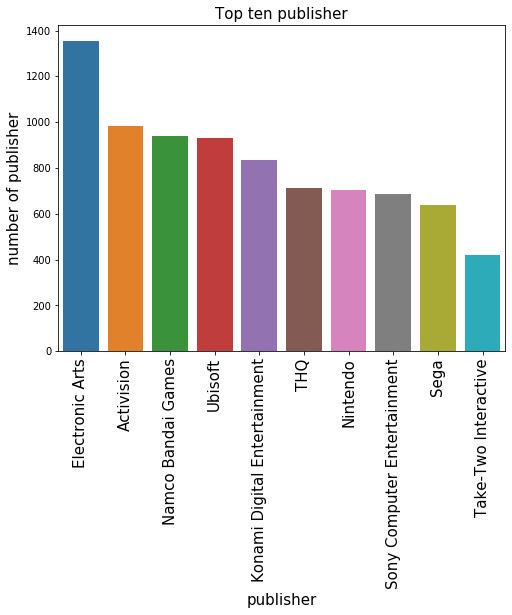

In [30]:
publisher = Counter(df['Publisher'].dropna().tolist()).most_common(10)
publisher_name = [name[0] for name in publisher]
publisher_count = [name[1] for name in publisher]

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=publisher_name,y=publisher_count,ax=ax)
plt.title('Top ten publisher',fontsize=15)
plt.ylabel('number of publisher',fontsize=15)
plt.xlabel('publisher',fontsize=15)
ticks = plt.setp(ax.get_xticklabels(),fontsize=15,rotation=90)

In [31]:
publisher_sales = df[['Publisher', 'NA_players', 'EU_players' , 'JP_players']]
publishers = df.dropna(subset=['Publisher']).groupby('Publisher')[['NA_players', 'EU_players', 'JP_players']].sum().sort_values('NA_players', ascending=False)
publishers['total_revenue'] = publishers[['NA_players', 'EU_players']].sum(axis=1)
display(publishers.head())

,NA_players,EU_players,JP_players,total_revenue
Publisher,,,,
Nintendo,816.97,419.01,458.15,1235.98
Electronic Arts,599.50,373.91,14.35,973.41
Activision,432.59,215.90,6.71,648.49
Sony Computer Entertainment,266.17,186.56,74.15,452.73
Ubisoft,252.74,161.99,7.52,414.73


# Parsing of Information from MetaCritic

In [32]:
scores = data2.copy()[['Name']].append(data2.copy()[['Name']]).append(data2.copy()[['Name']]).sort_values(by='Name').reset_index(drop=True)
platforms = ['playstation-4', 'xbox-one', 'pc']
scores['Platform'] = scores.apply(lambda row: platforms[row.name % 3], axis=1)
scores['Critic_Score'] = np.array(57)
scores['User_Score'] = np.array(57)

scores = scores.set_index(['Name', 'Platform'])
for name in tqdm(scores.index):
    game_url = name[0].strip().lower().replace(' ', '-').replace("'", '').replace(':', '')
    platform = name[1]
    if platform == 'pc' and name[0] == 'Destiny':
        continue
    html = requests.get(url + platform + '/' + game_url, headers=headers)
    if html.ok:
        soup = BeautifulSoup(html.text, 'html.parser')
        scores.loc[name, 'Critic_Score'] = soup.select('div[class*="metascore_w xlarge game"]')[0].text
        scores.loc[name, 'User_Score'] = soup.select('div[class*="metascore_w user large game"]')[0].text

scores = scores.loc[scores.apply(lambda row: row.Critic_Score != row.User_Score, axis=1)].reset_index()

In [33]:
convert_dict = {'Critic_Score': int, 'User_Score': float}
scores = scores.astype(convert_dict)
scores = scores.groupby('Name')[['Critic_Score', 'User_Score']].aggregate('mean')
scores.loc[:, 'User_Score'] = scores['User_Score'] * 10
scores.loc[:, ['Critic_Score', 'User_Score']] = np.floor(scores.values)
scores = scores.reset_index()
scores

,Name,Critic_Score,User_Score
0,Agents of mayhem,67.0,62.0
1,Aliens: Colonial Marines,45.0,35.0
2,Anthem,59.0,38.0
3,Assassin's Creed: Unity,70.0,44.0
4,Batman: Arkham Knight,80.0,60.0
5,Battlefield V,77.0,26.0
6,Call of Duty: Advanced Warfare,80.0,52.0
7,Destiny,75.0,58.0
8,Fallout 4,86.0,62.0
9,Fallout 76,51.0,29.0


In [34]:
overall = pd.merge(data2, scores, how='left', on='Name')

In [35]:
display(pd.DataFrame({
    'Name': data2['Name'],
    'Rate':data2.iloc[:, 1:7].mean(axis=1)
}))

,Name,Rate
0,Battlefield V,6.800000
1,Mafia III,6.366667
2,No Man's Sky,5.550000
3,Watch Dogs,5.933333
4,Assassin's Creed: Unity,6.633333
5,Call of Duty: Advanced Warfare,6.950000
6,Fallout 76,5.200000
7,Batman: Arkham Knight,7.416667
8,Warcraft III: Reforged,6.166667
9,Aliens: Colonial Marines,5.933333


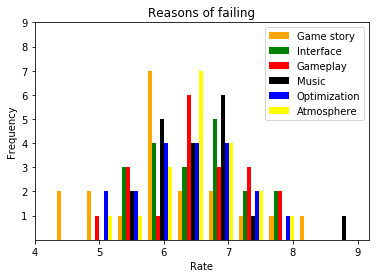

In [36]:
plt.hist(data2.iloc[:, 1:7].values,
         color=['orange', 'green' ,'red', 'black', 'blue', 'yellow'])
plt.xlabel("Rate")
plt.ylabel("Frequency")
plt.legend(data2.columns[1:7])
plt.xticks(range(4, 10))
plt.yticks(range(1, 10))
plt.title('Reasons of failing')
plt.show()

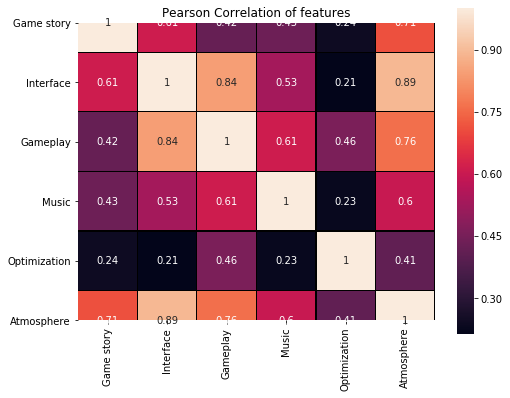

In [37]:
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
sns.heatmap(data2.iloc[:, 1:7].corr(), 
            linewidths=0.25,
            vmax=1.0, 
            square=True,  
            linecolor='k', 
            annot=True)
plt.show()

D:\Program Files\Anaconda 3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Program Files\Anaconda 3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


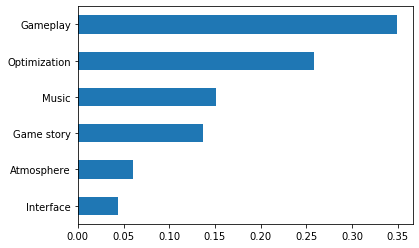

In [82]:
X = overall[['Game story', 'Interface', 'Gameplay', 'Music', 'Optimization', 'Atmosphere']]  #independent columns
y = overall[['User_Score']]    #target column i.e price range
model = RandomForestRegressor()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nsmallest(6).plot(kind='barh')
plt.show()